In [1]:
most_common_TFs = [
    "Id4", "Zic1", "Id2", "Celf4", "Neurod1",
    "Uqcrb", "Neurod2", "Ywhae", "Ncald", "Adarb1",
    "Etv1", "Smarca4", "Prnp", "Gpd1", "Tcf4",
    "Smarcc2", "Gtf2i", "Bcl6", "Rora", "Dnmt3a"
]


In [12]:
import sys

sys.path.append("/hpc/home/ps325/projects/velorama/velorama")

import gaston_dynamics as gd
import scanpy as sc
import numpy as np 
import pandas as pd


In [14]:
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

sys.path.append("/hpc/home/ps325/projects/gaston-velorama/src/gaston-base")

import gaston


import seaborn as sns
import math

In [16]:
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

In [4]:
CDATADIR = "gaston-base/gaston/docs/notebooks/tutorials/"
counts_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load(CDATADIR + 'cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load(CDATADIR + 'cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes
print(counts_mat.shape)

(9985, 23096)


In [5]:
A=np.load(CDATADIR + 'cerebellum_data/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [6]:
# gaston_model, A, S = gd.gaston_model('tutorial_outputs', S_torch, A_torch)
gaston_model, A, S= process_NN_output.process_files(CDATADIR + 'cerebellum_data/reproduce_cerebellum')


best model: gaston-base/gaston/docs/notebooks/tutorials/cerebellum_data/reproduce_cerebellum/seed19


In [7]:
CDATADIR = "gaston-base/gaston/docs/notebooks/tutorials/"


In [8]:
cell_type_mod_df = gd.create_cell_type_df(CDATADIR + 'cerebellum_data/cell_type_df.csv')

In [18]:
from importlib import reload
reload(gd)
gaston_isodepth, gaston_labels = gd.calculate_isodepth(gaston_model, A, S, coords_mat, num_layers=4,
    scale_factor=64/100, flip=True, adjust = True)

In [19]:
import warnings
warnings.filterwarnings("ignore")
ct_list= ['Oligodendrocytes', 'Granule', 'Bergmann', 'Purkinje', 'MLI1', 'MLI2']
cell_type_df=pd.read_csv(CDATADIR + 'cerebellum_data/cell_type_df.csv', index_col=0)
pw_fit_dict, binning_output = gd.binning_output(counts_mat, gene_labels, gaston_labels, gaston_isodepth, cell_type_df, ct_list)

Poisson regression for ALL cell types


100%|██████████| 2193/2193 [00:29<00:00, 75.33it/s]


Poisson regression for cell type: Oligodendrocytes


100%|██████████| 2193/2193 [00:25<00:00, 84.88it/s]


Poisson regression for cell type: Granule


100%|██████████| 2193/2193 [00:28<00:00, 77.95it/s]


Poisson regression for cell type: Bergmann


100%|██████████| 2193/2193 [00:19<00:00, 110.85it/s]


Poisson regression for cell type: Purkinje


100%|██████████| 2193/2193 [00:17<00:00, 122.41it/s]


Poisson regression for cell type: MLI1


100%|██████████| 2193/2193 [00:19<00:00, 110.88it/s]


Poisson regression for cell type: MLI2


100%|██████████| 2193/2193 [00:19<00:00, 111.96it/s]


(9985, 23096)
Graph construction completed in 0.0596 seconds


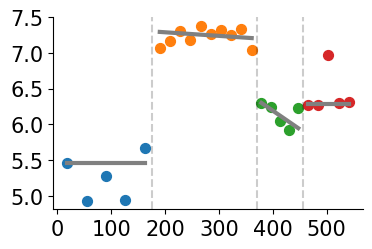

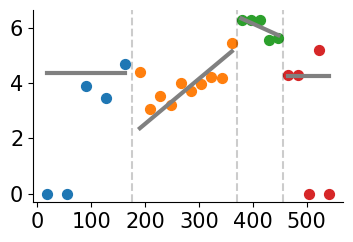

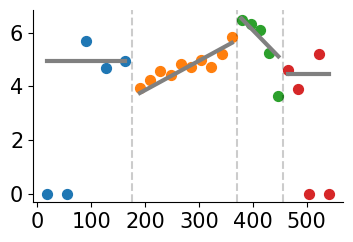

In [20]:
df = pd.DataFrame(counts_mat, columns=gene_labels)
adata=sc.AnnData(df)
adata.obsm["coords"] = coords_mat
print(adata.shape)
dag_adjacency_matrix = gd.construct_dag(adata, gaston_isodepth, coords_mat, n_neighbors=7, plot=False)
gd.create_tf_targets(adata, pw_fit_dict, binning_output, q=0.8, file = 'transcription_factors.txt')
# adata.write('/hpc/home/ps325/projects/velorama/datasets/gaston_dynamics_test_mod_q8_flip.h5ad')


gene_name = ["Zic1", "Id4", "Id2"]

for gene in gene_name:
    binning_and_plotting.plot_gene_pwlinear(gene, pw_fit_dict, gaston_labels, gaston_isodepth, 
                                            binning_output, cell_type_list=None, pt_size=50, colors=None, 
                                            linear_fit=True, ticksize=15, figsize=(4,2.5), offset=10**6, lw=3,
                                           domain_boundary_plotting=True)


In [51]:
def plot_gene_pwlinear(gene_name_list, pw_fit_dict, gaston_labels, gaston_isodepth, binning_output,
                       pt_size=10, colors=None, ticksize=20, figsize=(7,3),offset=10**6, 
                       xticks=None, yticks=None, alpha=1, domain_boundary_plotting=False, 
                      save=False, save_dir="./", variable_spot_size=False, show_lgd=False,
                      lgd_bbox=(1.05,1), extract_values = False):
    
    gene_labels_idx=binning_output['gene_labels_idx']
    gene_list=np.array([np.where(gene_labels_idx==gene_name)[0] for gene_name in gene_name_list])
    
    unique_binned_isodepths=binning_output['unique_binned_isodepths']
    binned_labels=binning_output['binned_labels']
    
    binned_count=binning_output['binned_count']
    binned_exposure=binning_output['binned_exposure']
    
    segs=binning_output['segs']
    L=len(segs)

    fig,ax=plt.subplots(figsize=figsize)

    if domain_list is None:
        domain_list=range(L)

    values_list = []
    for seg in domain_list:

        pts_seg=np.where(binned_labels==seg)[0]
        to_subtract=np.log( offset*1 / np.mean(binned_exposure) )

        # set colors for domains
        if colors is None:
            c=None
        else:
            c=colors[seg]
            
        xax=unique_binned_isodepths[pts_seg]
        binned_count_sum=np.sum(binned_count[pts_seg,gene_list],1)
        yax=np.log((binned_count_sum / binned_exposure[pts_seg]) * offset + 1)

        if extract_values:
            values_list.append(np.column_stack((xax, yax)))
        
        s=pt_size
        if variable_spot_size:
            s=s*binning_output['binned_number_spots'][pts_seg]
        plt.scatter(xax, yax, color=c, s=s, alpha=alpha,label=ct)


    if xticks is None:
        plt.xticks(fontsize=ticksize)
    else:
        plt.xticks(xticks,fontsize=ticksize)
        
    if yticks is None:
        plt.yticks(fontsize=ticksize)
    else:
        plt.yticks(yticks,fontsize=ticksize)
        
    if domain_boundary_plotting and len(domain_list)>1:
        binned_labels=binning_output['binned_labels']
        
        left_bps=[]
        right_bps=[]

        for i in range(len(binned_labels)-1):
            if binned_labels[i] != binned_labels[i+1]:
                left_bps.append(unique_binned_isodepths[i])
                right_bps.append(unique_binned_isodepths[i+1])
        
        for i in domain_list[:-1]:
            plt.axvline((left_bps[i]+right_bps[i])*0.5, color='black', ls='--', linewidth=1.5, alpha=0.2)

    sns.despine()
    if show_lgd:
        plt.legend(bbox_to_anchor=lgd_bbox)
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/{gene_name}_pwlinear.pdf", bbox_inches="tight")
        plt.close()

    if extract_values:
        all_values = np.vstack(values_list)
        values_filename = f"{save_dir}/{gene_name}_raw_all.txt"
        save_values({gene_name: all_values}, values_filename)



             Cell_Type
0             Bergmann
1             Bergmann
2           Fibroblast
3                 MLI2
4              Granule
...                ...
9980  Oligodendrocytes
9981          Bergmann
9982           Granule
9983        Astrocytes
9984           Granule

[9985 rows x 1 columns]


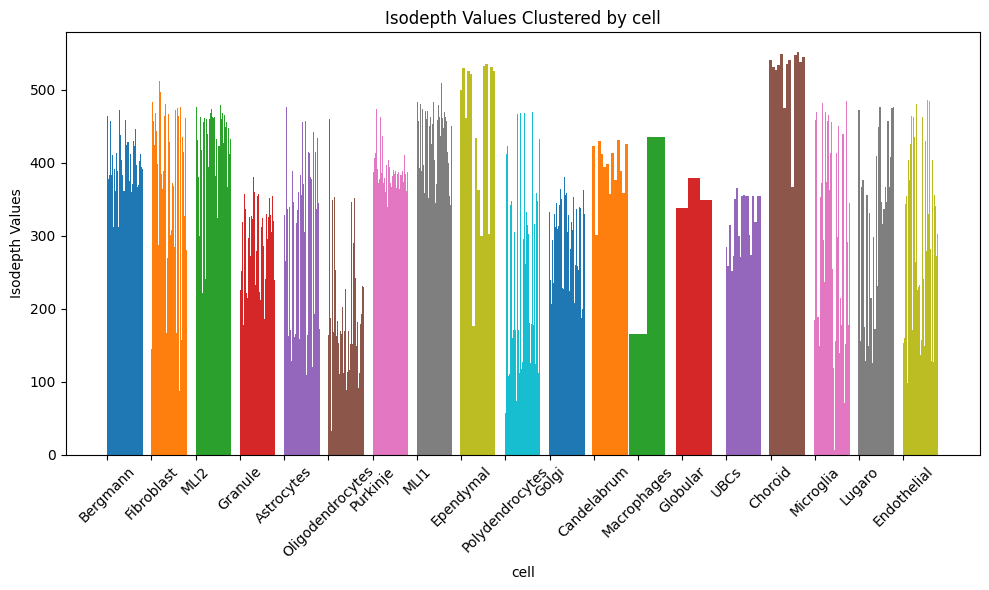

In [38]:
cell_dict = {}
for i, key in enumerate(cell_type_mod_df['Cell_Type']):
    cell_dict.setdefault(key, []).append(gaston_isodepth[i])

fig, ax = plt.subplots(figsize=(10, 6))


cells = list(cell_dict.keys())
bar_width = 0.8  # Width of each cell's cluster
x_positions = range(len(cells))  # Position of each cell on the x-axis

# Loop through each cell and plot individual isodepth values
for idx, cell in enumerate(cells):
    isodepth_values = cell_dict[cell]
    bar_positions = [idx + (offset * (bar_width / len(isodepth_values))) for offset in range(len(isodepth_values))]
    ax.bar(bar_positions, isodepth_values, width=bar_width / len(isodepth_values), label=cell if idx == 0 else "")

# Formatting the plot
ax.set_xlabel("cell")
ax.set_ylabel("Isodepth Values")
ax.set_title("Isodepth Values Clustered by cell")
ax.set_xticks(x_positions)
ax.set_xticklabels(cells, rotation=45)
plt.tight_layout()
plt.show()

In [50]:
print(len(gene_labels))
print(gene_labels)
print(len(gaston_isodepth))

23096
['0610005C13Rik' '0610007P14Rik' '0610009B22Rik' ... 'n-R5s173' 'n-R5s48'
 'n-R5s76']
9985
